In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing Libraries and unzipping the file that store my dataset**

In [ ]:
import zipfile
import os

In [ ]:
# zip_path='/content/drive/MyDrive/deep learning 3/ISIC 2016.zip'
# extract_path='/content/drive/MyDrive/deep learning 3'
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import os

# **Transformation used to covert dataset into (128,128) images and convert it into Tensor and normalize it using standard values**

In [ ]:
transform1=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform2=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# **Creating custom dataset class for train dataset and train mask to fetch it from directory and Apply Tranformation on it and making the dataloader of it**

In [ ]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform1=None, transform2=None):
        self.root_dir = root_dir
        self.transform1 = transform1
        self.transform2 = transform2
        self.image_folder = os.path.join(root_dir, 'train')
        self.mask_folder = os.path.join(root_dir, 'train_masks')
        self.image_name = os.listdir(self.image_folder)

    def __len__(self):
        return len(self.image_name)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_name[idx])
        mask_name = os.path.join(self.mask_folder, self.image_name[idx].replace('.jpg', '.png'))

        image = Image.open(img_name)
        mask = Image.open(mask_name)

        if self.transform1:
            image = self.transform1(image)

        if self.transform2:
            mask = self.transform2(mask)

        return image, mask

# Define the dataset with the appropriate transforms
dataset = customdataset(root_dir='/content/drive/MyDrive/deep learning 3/ISIC 2016',
                        transform1=transform1,
                        transform2=mask_transform2)

dataloader= DataLoader(dataset, batch_size=32, shuffle=True)

#model= torchvision.models.mobilenet_v2(pretrained=True).features
#print(model)

#for para in model.parameters():
  #para.requires_grad= False





# **Creating my Decoder Architecture and importing Mobilenet encoder features and making the segmentation class for combining the encoder and decoder and FREEZING THE PARAMETERS OF ENCODER**

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

class Decoder(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(Decoder, self).__init__()

        # Upsampling layers
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Forward pass through the decoder
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        #x = self.upsample(x)
        x = self.conv4(x)
        x = self.upsample2(x)
        return x

# Instantiate MobileNetV2 model
mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)
# Extract features until the final convolutional layer (before the classifier)
features = mobilenet_v2.features

for param in features.parameters():
    param.requires_grad = False


# Get the number of output channels from the MobileNetV2 feature extractor
#input_channels = mobilenet_v2.last_channel

# Define the number of classes for segmentation
num_classes = 1  # Assuming binary segmentation (1 channel mask)

# Instantiate the decoder
decoder = Decoder(input_channels=1280, num_classes=1)

# Combine MobileNetV2 features with the decoder
class SegmentationModel(nn.Module):
    def __init__(self, features, decoder):
        super(SegmentationModel, self).__init__()
        self.features = features
        self.decoder = decoder

    def forward(self, x):
        # Extract features from MobileNetV2
        x = self.features(x)
        # Pass features through the decoder
        x = self.decoder(x)
        return x

# Combine MobileNetV2 features with the decoder
segmentation_model = SegmentationModel(features, decoder)

# Print the combined model
#print(segmentation_model)


# **Creating the custom dataset class 2 for test dataset and apply transformation on it and making dataloader of it**

In [ ]:
class customdataset2(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform1=None, transform2=None):
        self.root_dir = root_dir
        self.transform1 = transform1
        self.transform2 = transform2
        self.image_folder = os.path.join(root_dir, 'test')
        self.mask_folder = os.path.join(root_dir, 'test_masks')
        self.image_name = os.listdir(self.image_folder)

    def __len__(self):
        return len(self.image_name)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_name[idx])
        mask_name = os.path.join(self.mask_folder, self.image_name[idx].replace('.jpg', '.png'))

        image = Image.open(img_name)
        mask = Image.open(mask_name)

        if self.transform1:
            image = self.transform1(image)

        if self.transform2:
            mask = self.transform2(mask)

        return image, mask

# Define the dataset with the appropriate transforms
dataset = customdataset2(root_dir='/content/drive/MyDrive/deep learning 3/ISIC 2016',
                        transform1=transform1,
                        transform2=mask_transform2)

test_dataloader= DataLoader(dataset, batch_size=len(dataset), shuffle=False)




# **Training the Model and validating it and plotting the Loss and accuracy of training and validation**

Epoch 1/10, Train Loss: 5.0270, Train Accuracy: 0.5502, Val Loss: 0.6856, Val Accuracy: 0.6797
Epoch 2/10, Train Loss: 0.6568, Train Accuracy: 0.7242, Val Loss: 0.5357, Val Accuracy: 0.7305
Epoch 3/10, Train Loss: 0.5123, Train Accuracy: 0.7704, Val Loss: 0.4809, Val Accuracy: 0.7683
Epoch 4/10, Train Loss: 0.4368, Train Accuracy: 0.7973, Val Loss: 0.4283, Val Accuracy: 0.8016
Epoch 5/10, Train Loss: 0.4299, Train Accuracy: 0.7982, Val Loss: 0.4893, Val Accuracy: 0.7935
Epoch 6/10, Train Loss: 0.4023, Train Accuracy: 0.8098, Val Loss: 0.4456, Val Accuracy: 0.8121
Epoch 7/10, Train Loss: 0.3835, Train Accuracy: 0.8159, Val Loss: 0.3635, Val Accuracy: 0.8195
Epoch 8/10, Train Loss: 0.3347, Train Accuracy: 0.8355, Val Loss: 0.3568, Val Accuracy: 0.8290
Epoch 9/10, Train Loss: 0.3120, Train Accuracy: 0.8473, Val Loss: 0.3468, Val Accuracy: 0.8340
Epoch 10/10, Train Loss: 0.3063, Train Accuracy: 0.8496, Val Loss: 0.4034, Val Accuracy: 0.8287


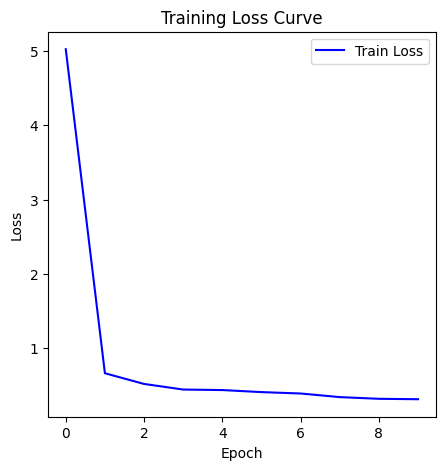

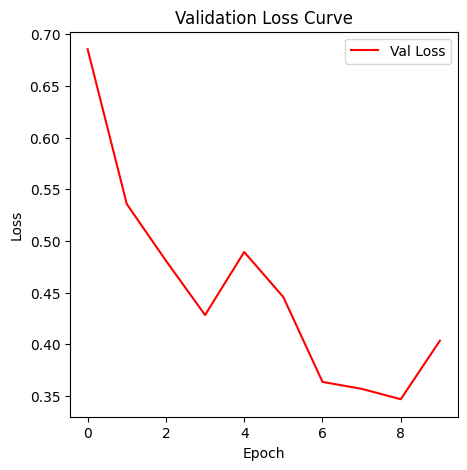

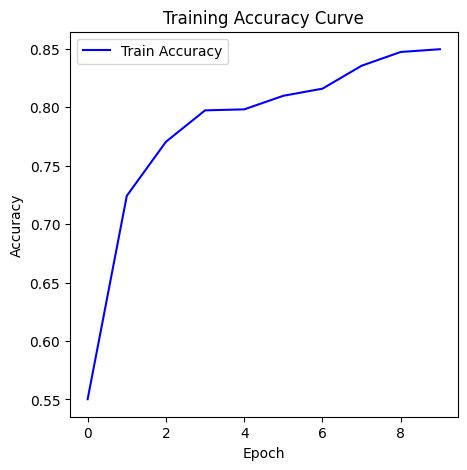

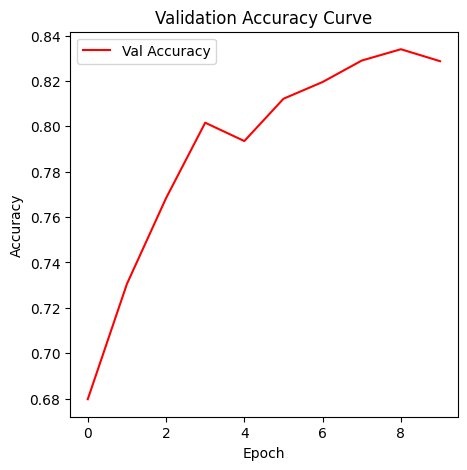

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define your loss function
criterion = nn.BCEWithLogitsLoss()

# Define your optimizer
#optimizer = optim.Adam(segmentation_model.parameters(), lr=0.001)
optimizer = optim.Adam(segmentation_model.decoder.parameters(), lr=0.001)

# Define your dataloaders for training and validation
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataset = customdataset2(root_dir='/content/drive/MyDrive/deep learning 3/ISIC 2016',
                        transform1=transform1,
                        transform2=mask_transform2)

val_dataloader= DataLoader(dataset, batch_size=32, shuffle=False)


# Define the number of epochs
num_epochs = 10

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    segmentation_model.train()  # Set the model to train mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    # Iterate over the training dataset
    for inputs, masks in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = segmentation_model(inputs)

        # Calculate the loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        running_train_loss += loss.item()

        # Calculate training accuracy
        predictions = (outputs > 0.5).float()
        correct_train_predictions += (predictions == masks).sum().item()
        total_train_predictions += masks.numel()

    # Calculate average training loss and accuracy for this epoch
    train_loss = running_train_loss / len(dataloader)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    segmentation_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    # Turn off gradients for validation
    with torch.no_grad():
        for inputs, masks in val_dataloader:
            outputs = segmentation_model(inputs)
            val_loss = criterion(outputs, masks)
            running_val_loss += val_loss.item()

            # Calculate validation accuracy
            predictions = (outputs > 0.5).float()
            correct_val_predictions += (predictions == masks).sum().item()
            total_val_predictions += masks.numel()

    # Calculate average validation loss and accuracy for this epoch
    val_loss = running_val_loss / len(val_dataloader)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting the loss curves
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure(figsize=(5, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()


# **Testing the model and calculating the IoU Score and Dice score**

In [ ]:
import torch

def intersection_over_union(outputs, masks, threshold=0.5):
    # Apply sigmoid activation to convert logits to probabilities
    probabilities = torch.sigmoid(outputs)
    # Convert probabilities to binary predictions using a threshold
    predictions = (probabilities > threshold).float()

    # Intersection and Union
    intersection = torch.sum(predictions * masks)
    union = torch.sum(predictions) + torch.sum(masks) - intersection

    # Avoid division by zero
    epsilon = 1e-7

    # Intersection over Union
    iou = (intersection + epsilon) / (union + epsilon)

    return iou

def dice_score(outputs, masks, threshold=0.5):
    # Apply sigmoid activation to convert logits to probabilities
    probabilities = torch.sigmoid(outputs)
    # Convert probabilities to binary predictions using a threshold
    predictions = (probabilities > threshold).float()

    # Intersection
    intersection = torch.sum(predictions * masks)

    # Compute Dice Score
    dice_score = (2.0 * intersection) / (torch.sum(predictions) + torch.sum(masks))

    return dice_score

test_iou = 0.0
test_dice = 0.0
num_samples = 0

segmentation_model.eval()  # Set the model to evaluation mode

# Iterate through the test dataset
for images, masks in test_dataloader:
    with torch.no_grad():
        # Forward pass through the segmentation model
        outputs = segmentation_model(images)

        # Apply sigmoid activation to convert logits to probabilities
        probabilities = torch.sigmoid(outputs)

        # Convert probabilities to binary predictions using a threshold
        predictions = (probabilities > 0.5).float()  # Assuming threshold = 0.5

        # Compute IoU and Dice Score
        test_iou += intersection_over_union(outputs, masks)
        test_dice += dice_score(outputs, masks)

        num_samples += images.size(0)

# Calculate average IoU and Dice Score
average_iou = test_iou
average_dice = test_dice

print(f'Average Intersection over Union (IoU): {average_iou:.4f}')
print(f'Average Dice Score: {average_dice:.4f}')


Average Intersection over Union (IoU): 0.5721
Average Dice Score: 0.7278


# **Plotting the 5 Segmented images generated by my model and its corresponding masks**

Average Intersection over Union (IoU): 0.5721
Average Dice Score: 0.7278


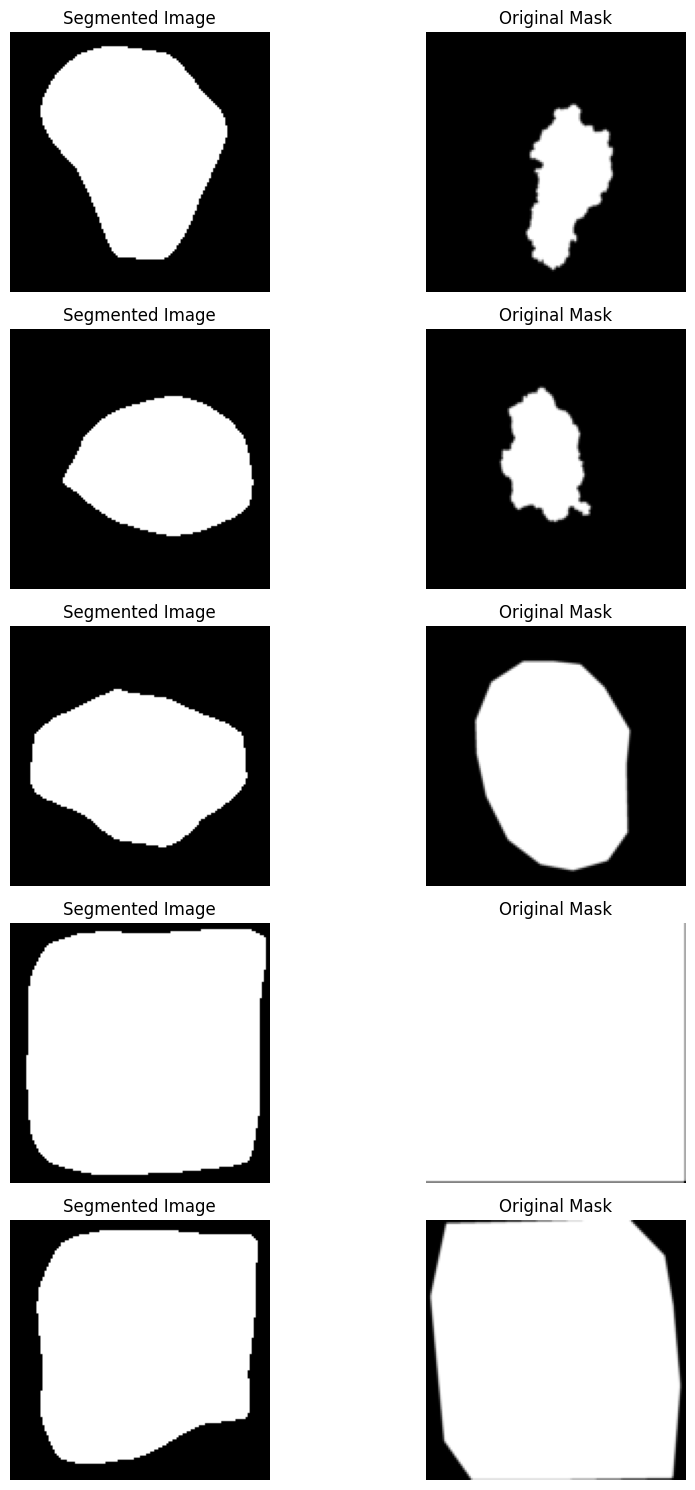

In [ ]:
import torch
import matplotlib.pyplot as plt

def intersection_over_union(outputs, masks, threshold=0.5):
    # Apply sigmoid activation to convert logits to probabilities
    probabilities = torch.sigmoid(outputs)
    # Convert probabilities to binary predictions using a threshold
    predictions = (probabilities > threshold).float()

    # Intersection and Union
    intersection = torch.sum(predictions * masks)
    union = torch.sum(predictions) + torch.sum(masks) - intersection

    # Avoid division by zero
    epsilon = 1e-7

    # Intersection over Union
    iou = (intersection + epsilon) / (union + epsilon)

    return iou

def dice_score(outputs, masks, threshold=0.5):
    # Apply sigmoid activation to convert logits to probabilities
    probabilities = torch.sigmoid(outputs)
    # Convert probabilities to binary predictions using a threshold
    predictions = (probabilities > threshold).float()

    # Intersection
    intersection = torch.sum(predictions * masks)

    # Compute Dice Score
    dice_score = (2.0 * intersection) / (torch.sum(predictions) + torch.sum(masks))

    return dice_score

test_iou = 0.0
test_dice = 0.0
num_samples = 0
segmented_images = []
segmented_masks = []

segmentation_model.eval()  # Set the model to evaluation mode

# Iterate through the test dataset
for images, masks in test_dataloader:
    with torch.no_grad():
        # Forward pass through the segmentation model
        outputs = segmentation_model(images)

        # Apply sigmoid activation to convert logits to probabilities
        probabilities = torch.sigmoid(outputs)

        # Convert probabilities to binary predictions using a threshold
        predictions = (probabilities > 0.5).float()  # Assuming threshold = 0.5

        # Compute IoU and Dice Score
        test_iou += intersection_over_union(predictions, masks)
        test_dice += dice_score(predictions, masks)

        num_samples += images.size(0)

        # Save segmented images and masks for plotting
        segmented_images.extend(predictions)
        segmented_masks.extend(masks)

# Calculate average IoU and Dice Score
# average_iou = test_iou
# average_dice = test_dice

print(f'Average Intersection over Union (IoU): {test_iou:.4f}')
print(f'Average Dice Score: {test_dice:.4f}')

# Plot some segmented images and their masks
num_samples_to_plot = 5  # Number of samples to plot
fig, axes = plt.subplots(num_samples_to_plot, 2, figsize=(10, 15))

for i in range(num_samples_to_plot):
    # Segmented image
    axes[i, 0].imshow(segmented_images[i].squeeze().cpu(), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Segmented Image')

    # Corresponding mask
    axes[i, 1].imshow(segmented_masks[i].squeeze().cpu(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Original Mask')

plt.tight_layout()
plt.show()


# **Unfreezing my encoder parameters and  Creating segmentation model 2 and finetuning its parameters and Training my model 2  and validating it and plotting the Graphs**

Epoch 1/10, Train Loss: 2.3955, Train Accuracy: 0.7322, Val Loss: 0.5537, Val Accuracy: 0.8267
Epoch 2/10, Train Loss: 0.2996, Train Accuracy: 0.8587, Val Loss: 0.2575, Val Accuracy: 0.8850
Epoch 3/10, Train Loss: 0.2601, Train Accuracy: 0.8786, Val Loss: 0.2167, Val Accuracy: 0.8973
Epoch 4/10, Train Loss: 0.2159, Train Accuracy: 0.8838, Val Loss: 0.1867, Val Accuracy: 0.9042
Epoch 5/10, Train Loss: 0.2050, Train Accuracy: 0.8928, Val Loss: 0.1766, Val Accuracy: 0.9050
Epoch 6/10, Train Loss: 0.1757, Train Accuracy: 0.9049, Val Loss: 0.1648, Val Accuracy: 0.9166
Epoch 7/10, Train Loss: 0.1528, Train Accuracy: 0.9144, Val Loss: 0.1566, Val Accuracy: 0.9186
Epoch 8/10, Train Loss: 0.1437, Train Accuracy: 0.9222, Val Loss: 0.1631, Val Accuracy: 0.9069
Epoch 9/10, Train Loss: 0.1433, Train Accuracy: 0.9200, Val Loss: 0.1600, Val Accuracy: 0.9130
Epoch 10/10, Train Loss: 0.1412, Train Accuracy: 0.9266, Val Loss: 0.1754, Val Accuracy: 0.9152


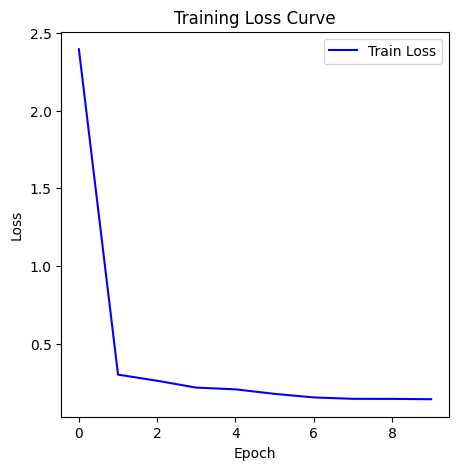

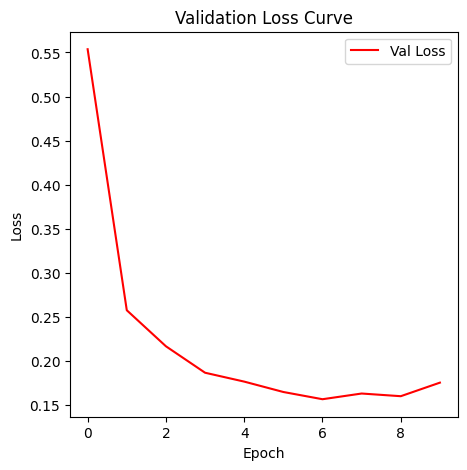

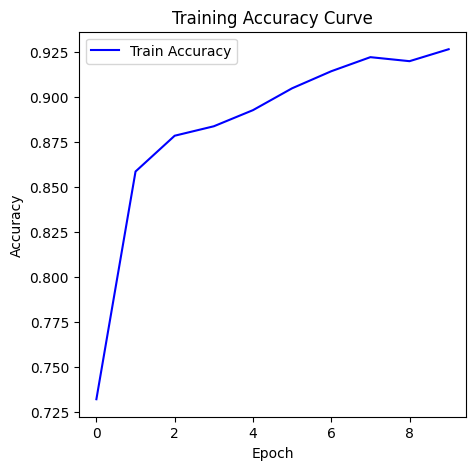

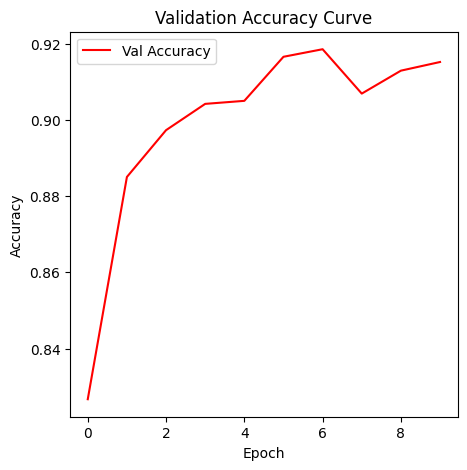

In [ ]:
for param in features.parameters():
    param.requires_grad = True

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

segmentation_model2 = SegmentationModel(features, decoder)
# Define your loss function
criterion = nn.BCEWithLogitsLoss()

# Define your optimizer
optimizer = optim.Adam(segmentation_model2.parameters(), lr=0.001)


num_epochs = 10

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    segmentation_model2.train()  # Set the model to train mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    # Iterate over the training dataset
    for inputs, masks in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = segmentation_model2(inputs)

        # Calculate the loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        running_train_loss += loss.item()

        # Calculate training accuracy
        predictions = (outputs > 0.5).float()
        correct_train_predictions += (predictions == masks).sum().item()
        total_train_predictions += masks.numel()

    # Calculate average training loss and accuracy for this epoch
    train_loss = running_train_loss / len(dataloader)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    segmentation_model2.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    # Turn off gradients for validation
    with torch.no_grad():
        for inputs, masks in val_dataloader:
            outputs = segmentation_model2(inputs)
            val_loss = criterion(outputs, masks)
            running_val_loss += val_loss.item()

            # Calculate validation accuracy
            predictions = (outputs > 0.5).float()
            correct_val_predictions += (predictions == masks).sum().item()
            total_val_predictions += masks.numel()

    # Calculate average validation loss and accuracy for this epoch
    val_loss = running_val_loss / len(val_dataloader)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting the loss curves
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure(figsize=(5, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()


# **Testing my model 2 and calculating the IoU score and Dice Score and plotting the segmented image and its corresponding masks**

Average Intersection over Union (IoU): 0.7795
Average Dice Score: 0.8761


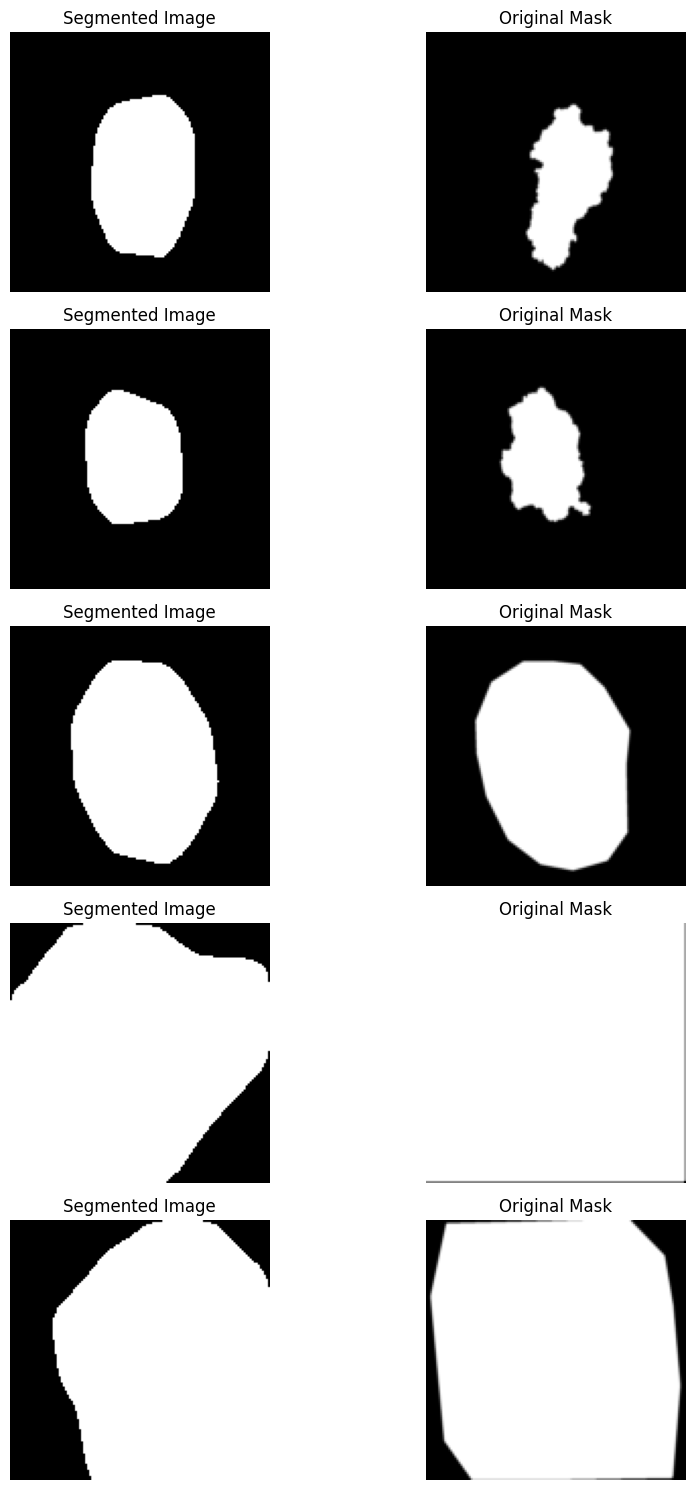

In [ ]:
import torch
import matplotlib.pyplot as plt

def intersection_over_union(outputs, masks, threshold=0.5):
    # Apply sigmoid activation to convert logits to probabilities
    probabilities = torch.sigmoid(outputs)
    # Convert probabilities to binary predictions using a threshold
    predictions = (probabilities > threshold).float()

    # Intersection and Union
    intersection = torch.sum(predictions * masks)
    union = torch.sum(predictions) + torch.sum(masks) - intersection

    # Avoid division by zero
    epsilon = 1e-7

    # Intersection over Union
    iou = (intersection + epsilon) / (union + epsilon)

    return iou

def dice_score(outputs, masks, threshold=0.5):
    # Apply sigmoid activation to convert logits to probabilities
    probabilities = torch.sigmoid(outputs)
    # Convert probabilities to binary predictions using a threshold
    predictions = (probabilities > threshold).float()

    # Intersection
    intersection = torch.sum(predictions * masks)

    # Compute Dice Score
    dice_score = (2.0 * intersection) / (torch.sum(predictions) + torch.sum(masks))

    return dice_score

test_iou = 0.0
test_dice = 0.0
num_samples = 0
segmented_images = []
segmented_masks = []

segmentation_model2.eval()  # Set the model to evaluation mode

# Iterate through the test dataset
for images, masks in test_dataloader:
    with torch.no_grad():
        # Forward pass through the segmentation model
        outputs = segmentation_model2(images)

        # Apply sigmoid activation to convert logits to probabilities
        probabilities = torch.sigmoid(outputs)

        # Convert probabilities to binary predictions using a threshold
        predictions = (probabilities > 0.5).float()  # Assuming threshold = 0.5

        # Compute IoU and Dice Score
        test_iou += intersection_over_union(predictions, masks)
        test_dice += dice_score(predictions, masks)

        num_samples += images.size(0)

        # Save segmented images and masks for plotting
        segmented_images.extend(predictions)
        segmented_masks.extend(masks)

# Calculate average IoU and Dice Score
# average_iou = test_iou
# average_dice = test_dice

print(f'Average Intersection over Union (IoU): {test_iou:.4f}')
print(f'Average Dice Score: {test_dice:.4f}')

# Plot some segmented images and their masks
num_samples_to_plot = 5  # Number of samples to plot
fig, axes = plt.subplots(num_samples_to_plot, 2, figsize=(10, 15))

for i in range(num_samples_to_plot):
    # Segmented image
    axes[i, 0].imshow(segmented_images[i].squeeze().cpu(), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Segmented Image')

    # Corresponding mask
    axes[i, 1].imshow(segmented_masks[i].squeeze().cpu(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Original Mask')

plt.tight_layout()
plt.show()
